In [1]:
%pylab notebook

import pandas as pd
import numpy as np
import datetime
import os

import ipywidgets as widgets

from cognite.config import configure_session
from cognite.v05.timeseries import get_datapoints_frame, get_timeseries
from cognite.v05.assets import get_asset, get_assets, get_asset_subtree
from cognite.v05.events import get_events, get_event, search_for_events

Populating the interactive namespace from numpy and matplotlib


In [2]:
configure_session(os.environ.get('Public_key'), 'publicdata')

In [38]:
p_in_tag  = 'VAL_23-PT-92532:X.Value'
T_in_tag  = 'VAL_23_TT_92532:Z.X.Value'
Q_tag     = 'VAL_23-FT-92537-01:X.Value'
p_out_tag = 'VAL_23-PT-92539:X.Value'
T_out_tag = 'VAL_23_TT_92536:Z.X.Value'
all_tags  = [p_in_tag, T_in_tag, Q_tag, T_out_tag, p_out_tag]

In [8]:
# Training - test set
# Question: Why not random?

train_start = datetime.datetime(2014, 1, 1)
train_end   = datetime.datetime(2016, 1, 1)
predict_end = datetime.datetime(2017, 1, 1)

start = train_start
end = predict_end
data = get_datapoints_frame(all_tags, 
                            start=start, 
                            end=end,
                            granularity='10m', 
                            aggregates=['avg'])

ConnectionError: HTTPSConnectionPool(host='api.cognitedata.com', port=443): Max retries exceeded with url: /api/0.5/projects/publicdata/timeseries/dataframe (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x109288978>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [6]:
df = data.fillna(method='ffill')
df = df.fillna(method='bfill')

In [9]:
train_cond = df.timestamp < train_end.timestamp()*1000
df_train = df[train_cond]
df_test  = df[~train_cond]

In [10]:
X_train = df_train.drop(['timestamp'], axis=1)
X_test  = df_test.drop(['timestamp'], axis=1)
t_train = pd.to_datetime(df_train.timestamp, unit='ms')
t_test  = pd.to_datetime(df_test.timestamp, unit='ms')

In [44]:
# KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


mxscaler = MinMaxScaler()
km = KMeans(n_clusters=2)
Z = mxscaler.fit_transform(X_train)
km.fit(Z)

labels= km.predict(Z)
Zred = Z[labels==0]

In [45]:
# Autoenc
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler

inn_point = Input(shape=(5,))
encoded = Dense(4, activation='relu')(inn_point)
decoded = Dense(5, activation='sigmoid')(encoded)
autoencoder = Model(inn_point, decoded)
opt = optimizers.SGD(lr=1)

autoencoder.compile(optimizer=opt, loss='MSE')
autoencoder.fit(Zred, Zred,
                epochs=50,
                batch_size=256
                )

Epoch 1/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0037A: 0s - los
Epoch 2/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0015
Epoch 3/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0015
Epoch 4/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0014
Epoch 5/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0014
Epoch 6/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0013
Epoch 7/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0012
Epoch 8/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0012
Epoch 9/50
99383/99383 [==============================] - 1s 6us/step - loss: 0.0011
Epoch 10/50
99383/99383 [==============================] - 1s 6us/step - loss: 9.8043e-04
Epoch 11/50
99383/99383 [==============================] - 1s 6us/step - loss: 8.8188e-04
Epoch 12/50
99383/99383 [===================

In [46]:
Z_test = mxscaler.transform(X_test)
labels_test = km.predict(Z_test)
Z_test_red = Z_test[labels_test==0]
t_test_red = t_test[labels_test==0]

In [47]:
P_test_red = autoencoder.predict(Z_test_red)
P_test_red = pd.DataFrame(data=P_test_red, columns=X_test.columns)
Z_test_red = pd.DataFrame(data=Z_test_red, columns=X_test.columns)

<IPython.core.display.Javascript object>


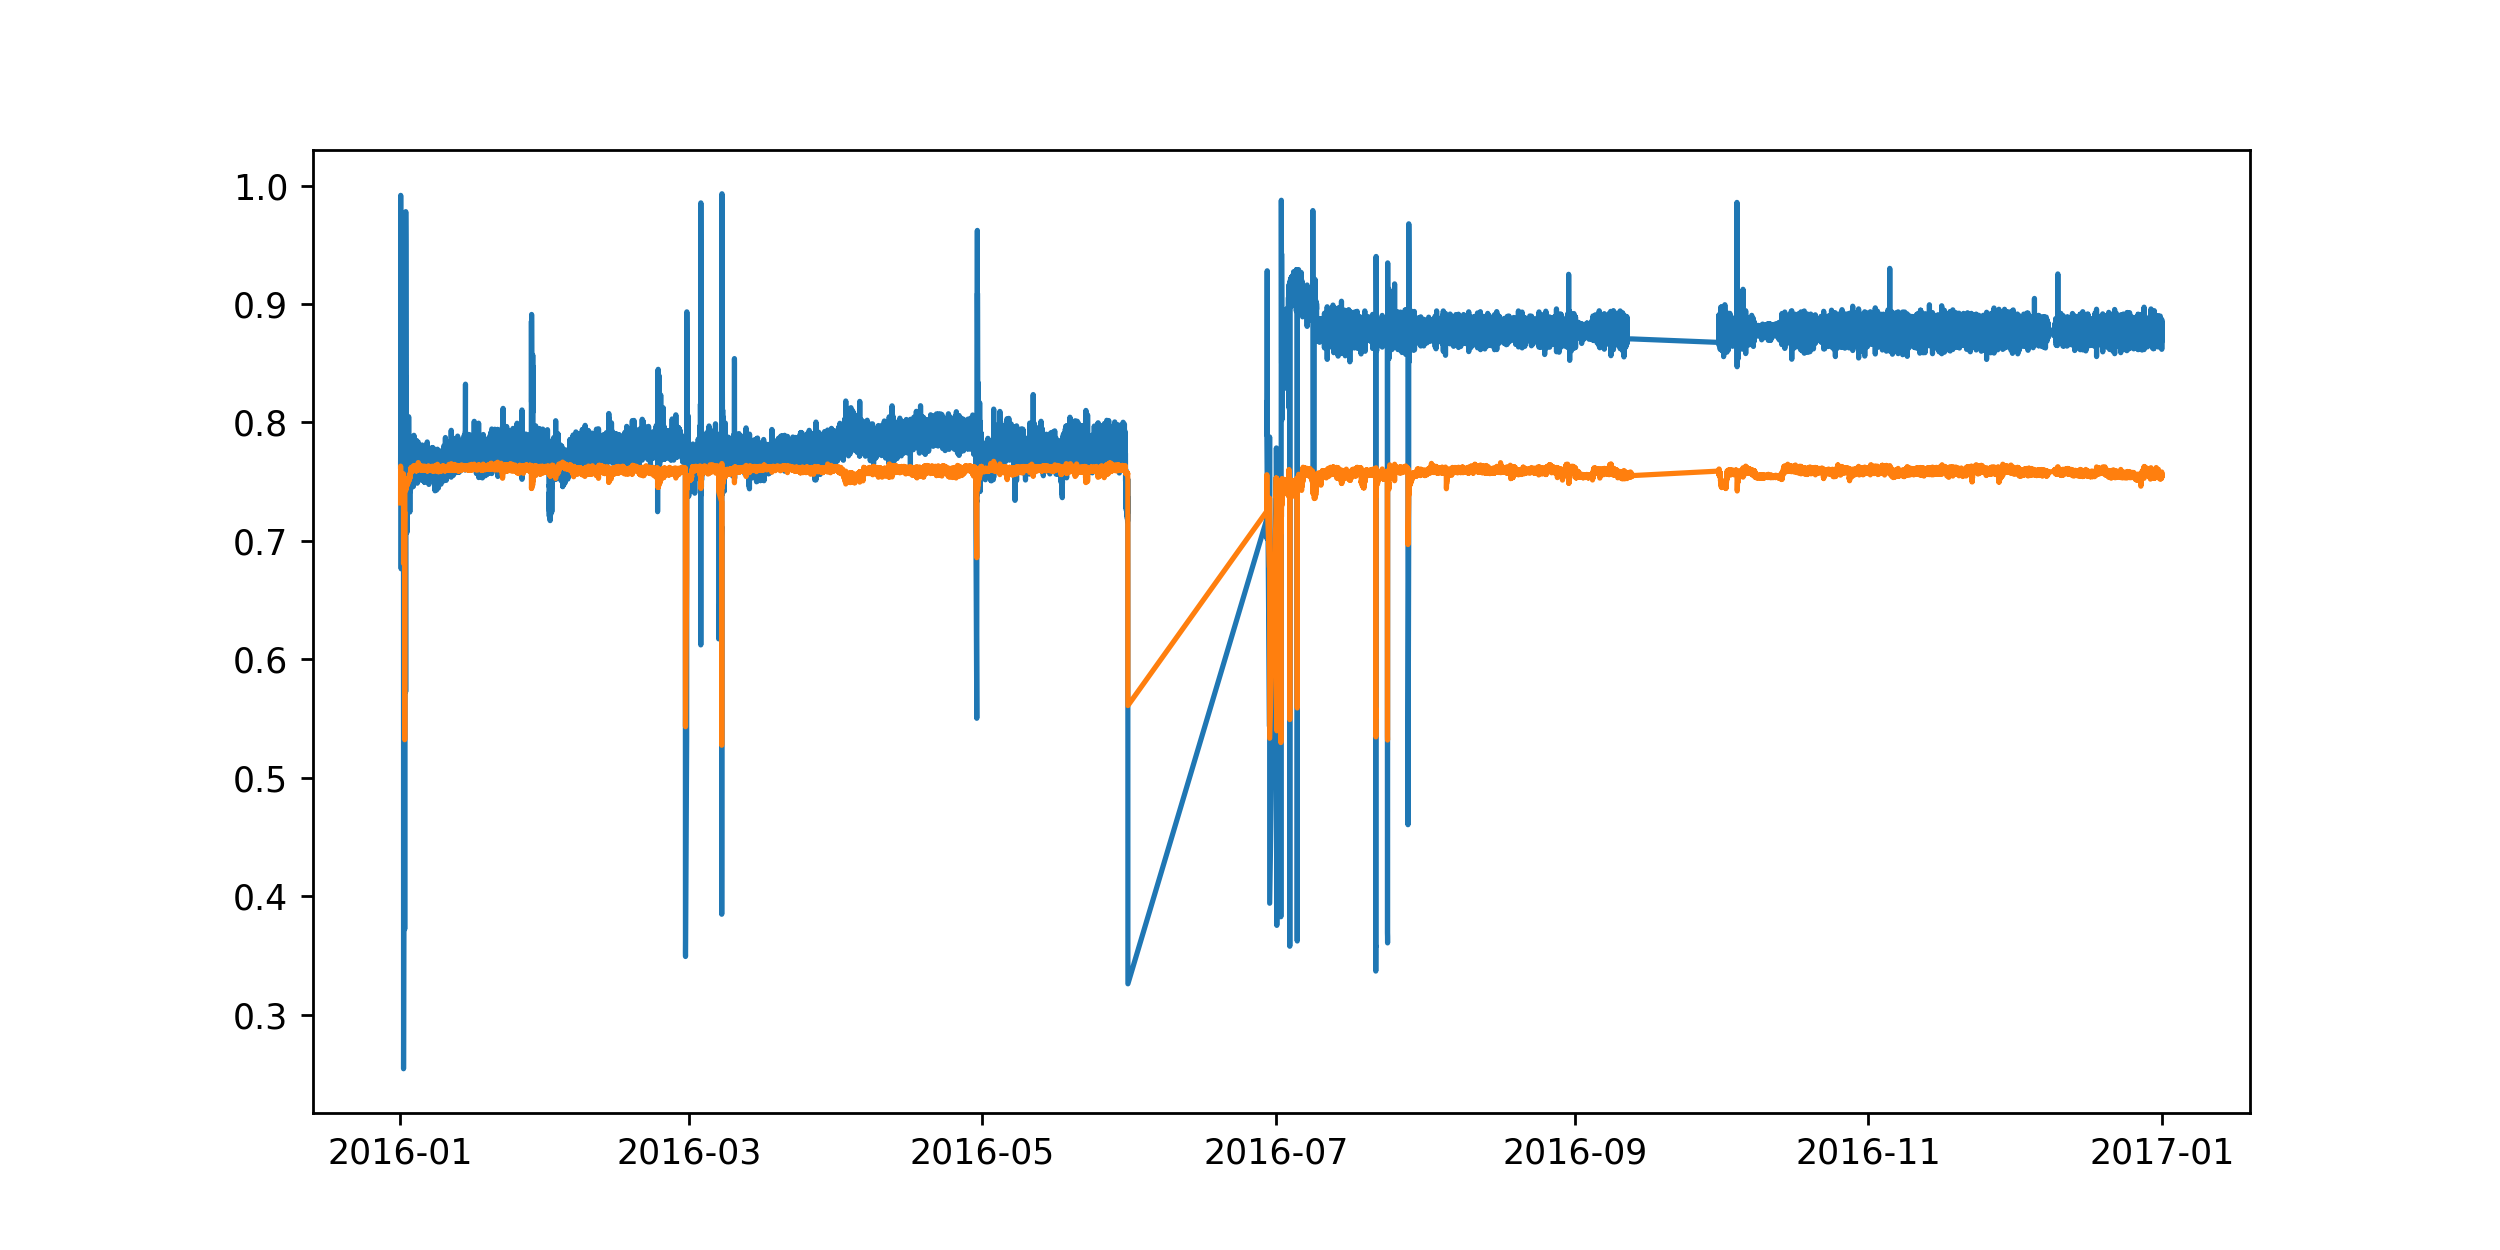

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(t_test, np.abs(Z_test[p_out_tag+'|average']-P_test[p_out_tag+'|average']))
ax.plot(t_test_red, np.abs(Z_test_red[p_out_tag+'|average']))
ax.plot(t_test_red, np.abs(P_test_red[p_out_tag+'|average']))



<IPython.core.display.Javascript object>


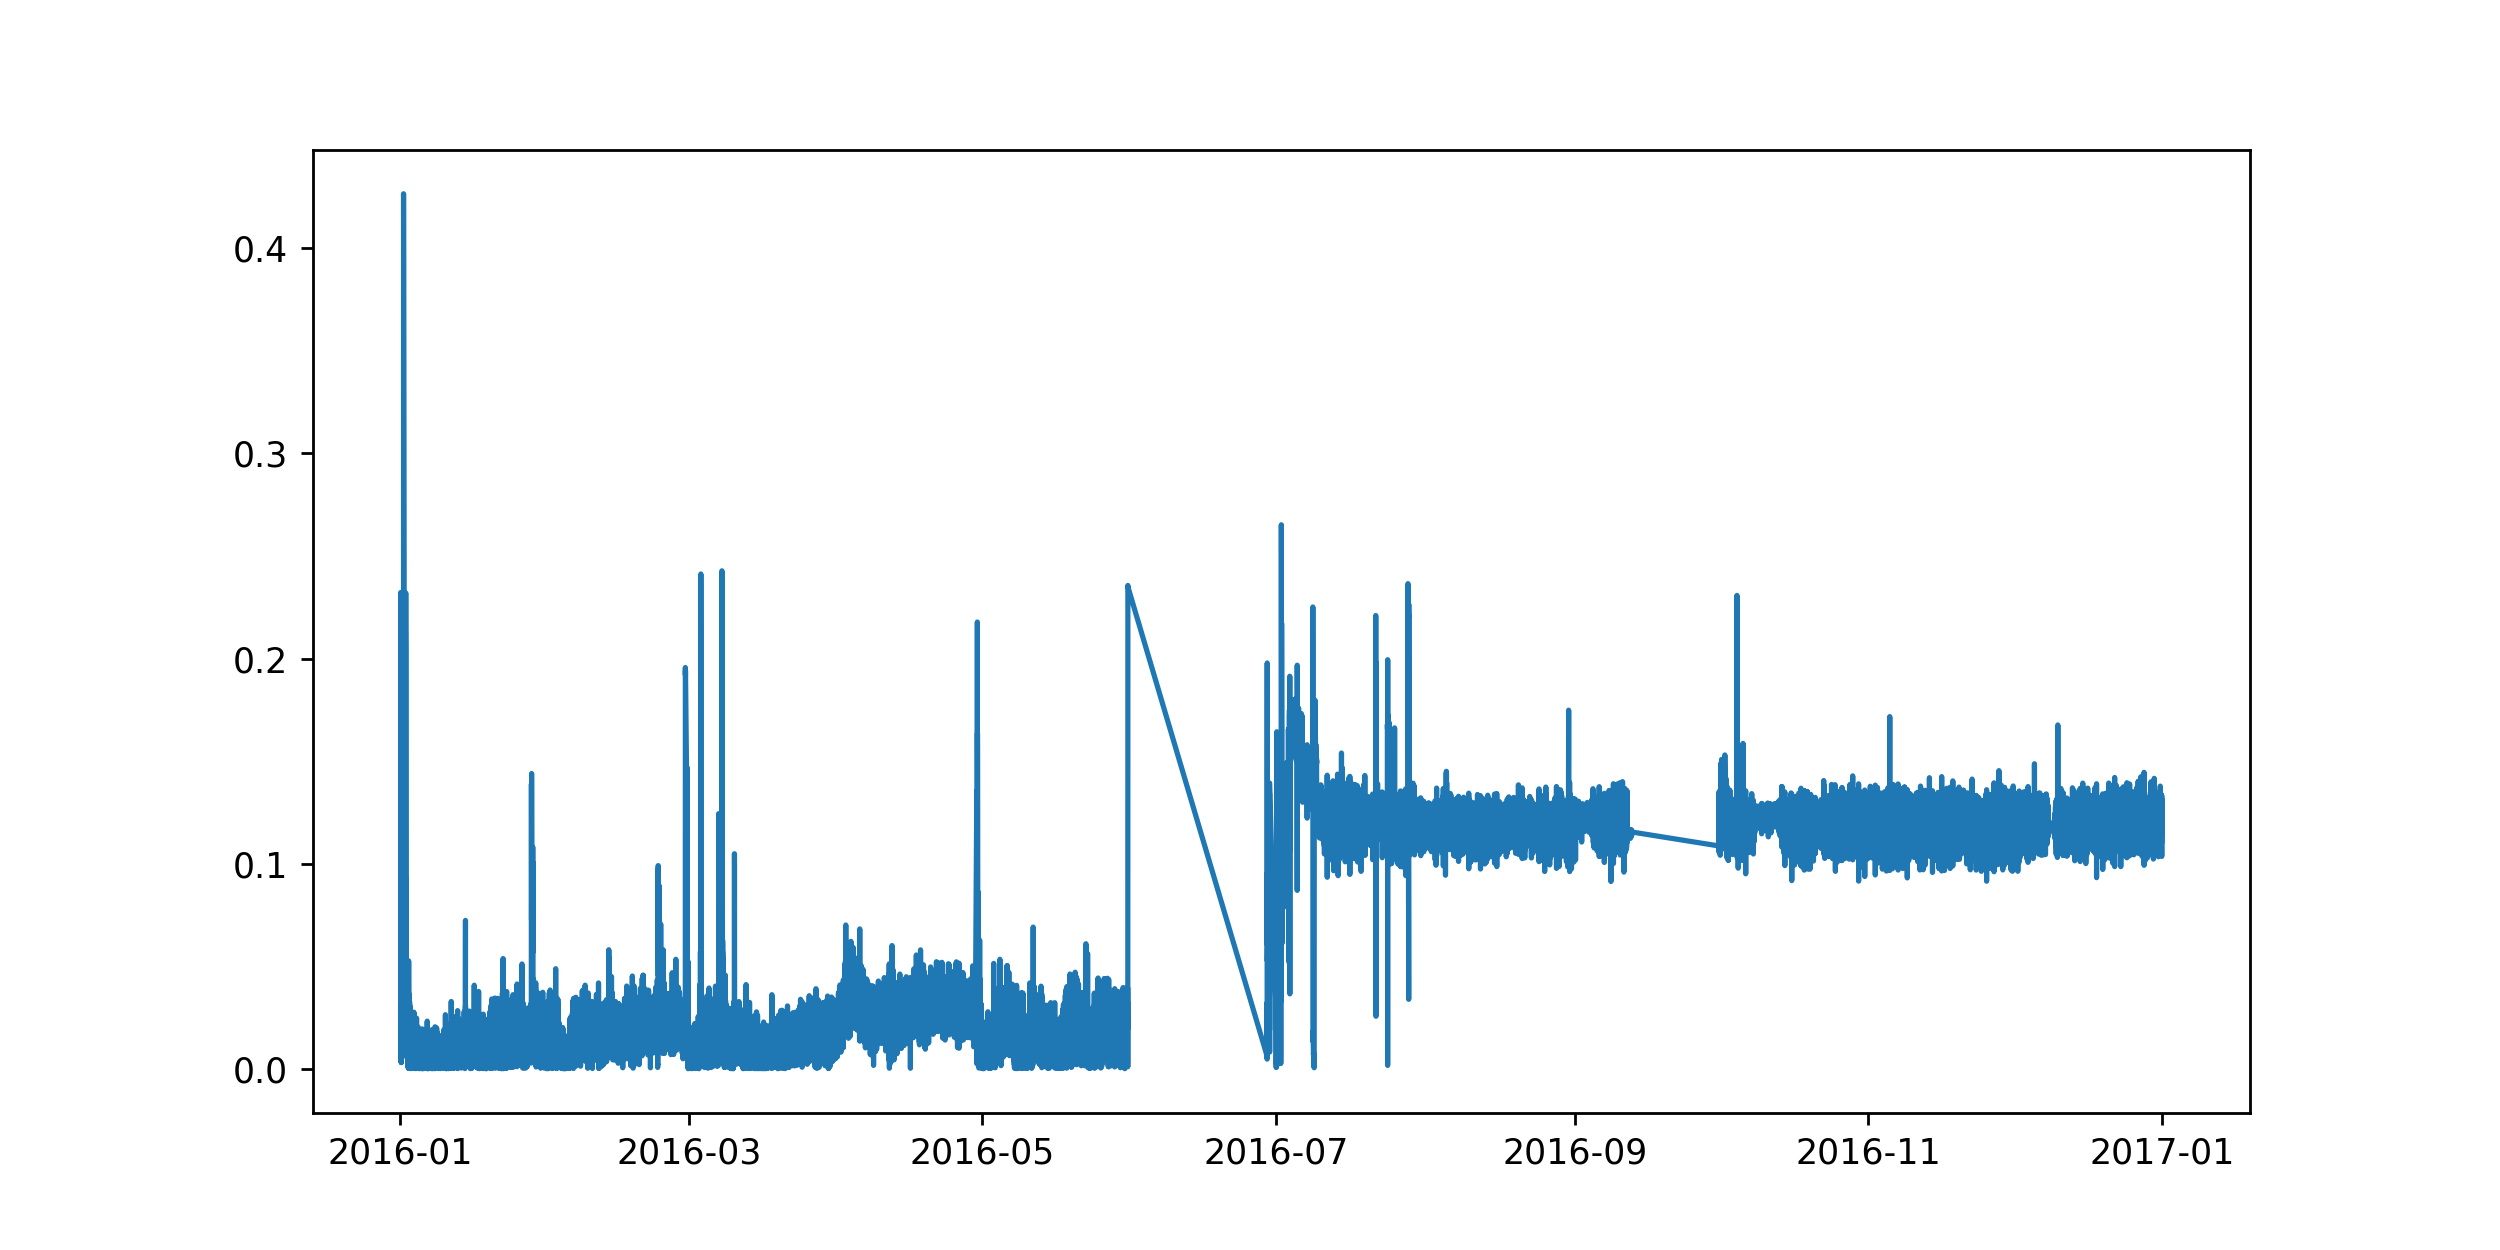

In [51]:
e = np.abs(Z_test_red[p_out_tag+'|average']-P_test_red[p_out_tag+'|average'])
real_e = np.sum(np.abs(Z_test_red.values - P_test_red.values)**2, axis=1)**0.5
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(t_test_red, e)
#plt.plot(t_test, real_e, '--')